In [ ]:
# Use Keras to do the anomaly detections , i may also code it with pytorch
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [ ]:
#Downloading dataset from googleapis
zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip',
                                   fname='PlantVillage.zip', extract=True)

856839084/856839084 [==============================] - 31s 0us/step


In [ ]:
#Split Data into train , test , validation
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [ ]:
import os

def count_files(directory):
    counter = sum(len(files) for _, _, files in os.walk(directory))
    return f"{directory}: {counter} files"


In [ ]:
print('total images for training :', count_files(train_dir))
print('total images for validation :', count_files(validation_dir))

total images for training : /root/.keras/datasets/PlantVillage/train: 43444 files
total images for validation : /root/.keras/datasets/PlantVillage/validation: 10861 files


In [ ]:
!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
33dc8985c943175a7a1301fe034c01d69bebb8cf
   creating: Plant-Diseases-Detector-master/
   creating: Plant-Diseases-Detector-master/GreenDoctor/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.gitignore  
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/Project.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/codeStyleConfig.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/encodings.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/jarRepositories.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/misc.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/runConfigurations.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/vcs.xml  
   creating: Plant-Diseases-Detector-master/GreenDoctor

In [ ]:
#Show some diseases that exectes in internet
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())

print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
print('Number of classes:',len(classes))
#In the end there's 38 classes in this dataset we can have more

Number of classes: 38


In [ ]:
#Start creating the module also the batch for learning phase
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [ ]:
#Data Normalization to go from [0;255] to [0;1]
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


In [ ]:
#Time to build model using Hub & Keras Layers , it's also based on fine tuning of existing model
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True

else:
  feature_extractor.trainable = False


In [ ]:
#The Structure
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                19494     
                                                                 
Total params: 22871366 (87.25 MB)
Trainable params: 1068582 (4.08 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
#Use Adam to optimize this part
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


In [ ]:
#LEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEETS LUNCH THE LEARNING PHASE
EPOCHS=5 #@param {type:"integer"}

history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/5
678/678 [==============================] - 1069s 2s/step - loss: 0.8364 - accuracy: 0.7627 - val_loss: 0.4322 - val_accuracy: 0.8661
Epoch 2/5
678/678 [==============================] - 1050s 2s/step - loss: 0.4090 - accuracy: 0.8696 - val_loss: 0.3124 - val_accuracy: 0.9010
Epoch 3/5
678/678 [==============================] - 1048s 2s/step - loss: 0.3517 - accuracy: 0.8883 - val_loss: 0.2872 - val_accuracy: 0.9074
Epoch 4/5
678/678 [==============================] - 1044s 2s/step - loss: 0.3125 - accuracy: 0.8970 - val_loss: 0.2684 - val_accuracy: 0.9130
Epoch 5/5
678/678 [==============================] - 1043s 2s/step - loss: 0.3039 - accuracy: 0.9001 - val_loss: 0.2418 - val_accuracy: 0.9229


In [ ]:
# tests
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob
import numpy as np

def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255

    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/22702316-d732-4765-a70d-dabfba1e32b9___CREC_HLB 7082.JPG
1/1 [==============================] - 0s 26ms/step
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 0.999756


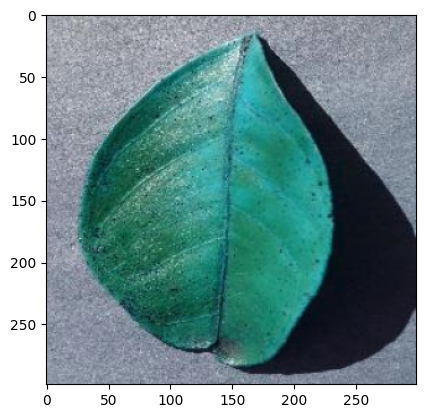

<Figure size 640x480 with 0 Axes>

SOURCE: class: Squash___Powdery_mildew, file: Squash___Powdery_mildew/d19bfbae-aff1-4b04-8720-2884c1a6149f___UMD_Powd.M 0636.JPG
1/1 [==============================] - 0s 26ms/step
PREDICTED: class: Tomato___Target_Spot, confidence: 0.594703


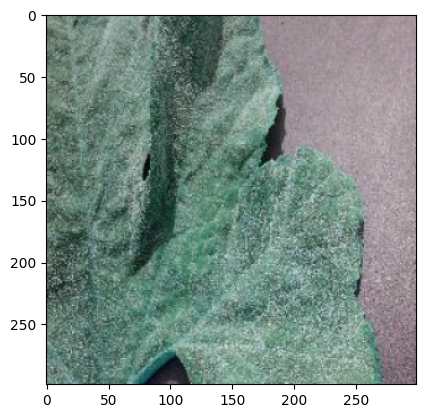

SOURCE: class: Pepper,_bell___healthy, file: Pepper,_bell___healthy/b6220cf3-e18d-4303-a7ed-cf60570bed93___JR_HL 5814.JPG
1/1 [==============================] - 0s 26ms/step
PREDICTED: class: Pepper,_bell___healthy, confidence: 0.912278


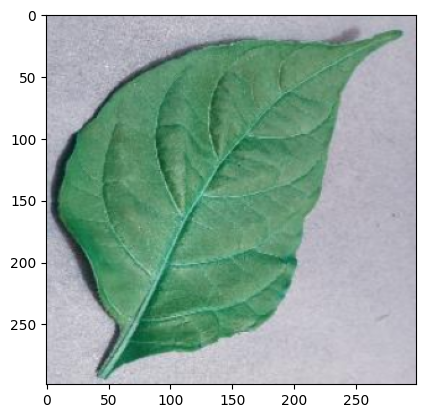

<Figure size 640x480 with 0 Axes>

SOURCE: class: Potato___Early_blight, file: Potato___Early_blight/dc6516c4-a74c-465f-85a1-55608ee518da___RS_Early.B 8843.JPG
1/1 [==============================] - 0s 50ms/step
PREDICTED: class: Tomato___Septoria_leaf_spot, confidence: 0.605235


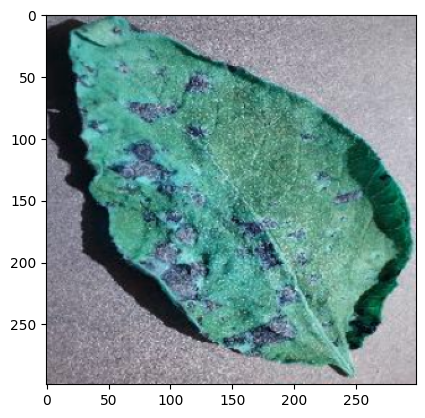

<Figure size 640x480 with 0 Axes>

SOURCE: class: Apple___Apple_scab, file: Apple___Apple_scab/659a6491-b20d-4ff6-a3be-243266b4df0c___FREC_Scab 3155.JPG
1/1 [==============================] - 0s 35ms/step
PREDICTED: class: Apple___Apple_scab, confidence: 0.591200


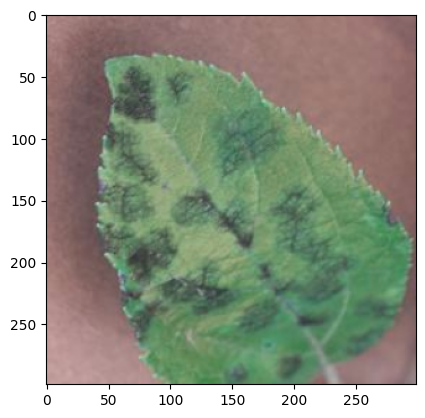

<Figure size 640x480 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.imshow(img)
    plt.figure(idx)
    plt.show()
    plt.figure(idx)
    plt.show()

In [ ]:
#save model in google drive
import time

t = int(time.time())

export_path = "/tmp/saved_models/{}".format(t)

model.save(export_path)

reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer': hub.KerasLayer})


In [ ]:
#reload Weights
loaded_model = tf.keras.models.load_model(export_path, custom_objects={'CustomLayer': CustomLayer})

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Define a function to load the model with custom objects
def load_model_with_custom_objects(model_path):
    # Define custom objects dictionary
    custom_objects = {'KerasLayer': hub.KerasLayer}

    # Load the model with custom objects
    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

    return loaded_model

# Specify the path to the saved model
model_path = "PlanetModel_20240319-095044.h5"

# Load the model with custom objects
loaded_model = load_model_with_custom_objects(model_path)


In [ ]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()